# VQ-VAE

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch.nn.functional as F
from datetime import datetime

In [2]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, dim_embeddings):
        super().__init__()

        self.num_embeddings = num_embeddings

        self.embedding = nn.Embedding(num_embeddings, dim_embeddings)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, x, return_indices=False):
        x_permuted = x.permute(0, 2, 3, 1).contiguous()
        x_flatted = x_permuted.view(-1, x.shape[1])

        # Using Broadcasting: (N, 1, dim_embeddings) - (num_embeddings, dim_embeddings) = (N, num_embeddings, dim_embeddings)
        indices = torch.norm(x_flatted.unsqueeze(1) - self.embedding.weight, dim=2).argmin(dim=1)

        if return_indices:
            return indices.view(x.shape[0], x.shape[2], x.shape[3])

        quantized = self.embedding(indices) # (-1, dim_embeddings)

        return quantized.view(x_permuted.shape).permute(0, 3, 1, 2)


print(VectorQuantizer(10, 100)(torch.randn(32, 100, 4, 4)).shape)
VectorQuantizer(10, 100)(torch.randn(32, 100, 4, 4), return_indices=True).shape

torch.Size([32, 100, 4, 4])


torch.Size([32, 4, 4])

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, kernel_size=1)
        )
    
    def forward(self, x):
        return x + self.net(x)
    
ResidualBlock(10, 20)(torch.randn(16, 10, 28, 28)).shape

torch.Size([16, 10, 28, 28])

In [4]:
class Encoder(nn.Module):
    def __init__(self, img_channels=3, dim_hidden=256):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(img_channels, dim_hidden, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim_hidden, dim_hidden, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(dim_hidden, dim_hidden),
            ResidualBlock(dim_hidden, dim_hidden),
            nn.Conv2d(in_channels=dim_hidden, out_channels=dim_hidden, kernel_size=1, stride=1)
        )
    
    def forward(self, x):
        return self.net(x)

Encoder()(torch.randn(16, 3, 28, 28)).shape

torch.Size([16, 256, 7, 7])

In [5]:
class Decoder(nn.Module):
    def __init__(self, dim_hidden=256, img_channels=3):
        super().__init__()

        self.net = nn.Sequential(
            ResidualBlock(dim_hidden, dim_hidden),
            ResidualBlock(dim_hidden, dim_hidden),
            nn.ConvTranspose2d(dim_hidden, dim_hidden, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(dim_hidden, img_channels, kernel_size=4, stride=2, padding=1),
        )
    
    def forward(self, x):
        return self.net(x)

Decoder()(torch.randn(16, 256, 7, 7)).shape

torch.Size([16, 3, 28, 28])

## Train on MNIST

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torchvision.datasets.MNIST('../../data/mnist', train=True, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(0.), tensor(1.))

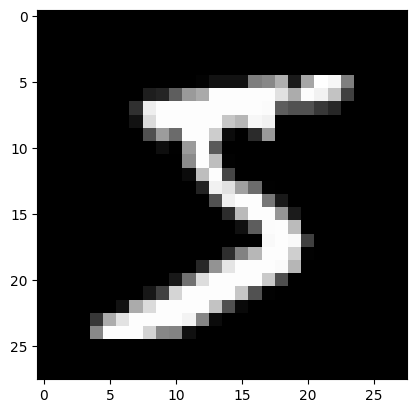

In [7]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [8]:
def show_images(images, nrow=8, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
data_variance = np.var(dataset.data.numpy() / 255.0)
data_variance

0.09493041879725218

In [11]:
LAMBDA_COMMITMENT = 0.25
NUM_EMBEDDINGS = 50
DIM_EMBEDDINGS = 64

In [12]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

encoder = Encoder(img_channels=1, dim_hidden=DIM_EMBEDDINGS).to(device)
decoder = Decoder(dim_hidden=DIM_EMBEDDINGS, img_channels=1).to(device)
vq = VectorQuantizer(num_embeddings=NUM_EMBEDDINGS, dim_embeddings=DIM_EMBEDDINGS).to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(vq.parameters()), lr=1e-3)

reconstruction_loss = nn.MSELoss()

Reconstruction: 0.13415378332138062 - loss2: 0.1380431354045868 - Commitment: 0.0345107838511467


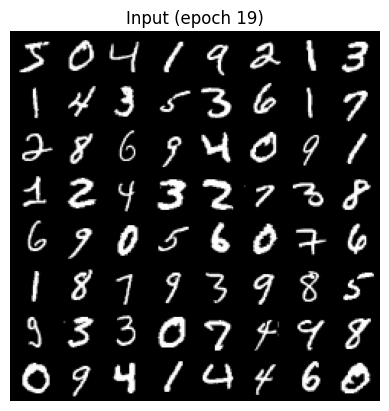

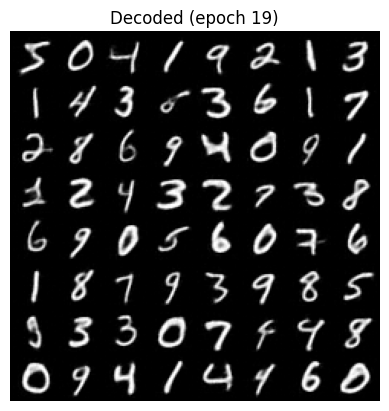

In [13]:
for epoch in range(20):
    epoch_loss = 0.

    for images, _ in train_loader:
        images = images.to(device)

        encoded = encoder(images)
        quantized = vq(encoded)
        decoded = decoder(encoded + (quantized - encoded).detach())

        loss2 = torch.norm(encoded.detach() - quantized)**2
        commitment_loss = LAMBDA_COMMITMENT * torch.norm(encoded - quantized.detach())**2
        recon_loss = reconstruction_loss(decoded, images) / data_variance
        loss = recon_loss + loss2 + commitment_loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # print(encoder.net[0].weight.grad is None)
        # print(vq.embedding.weight.grad is None)
        # print(decoder.net[2].weight.grad is None)
        # raise Exception("ASD")
    
    clear_output()
    print("Reconstruction:", recon_loss.item(), "- loss2:", loss2.item(), "- Commitment:", commitment_loss.item())
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    
    encoded = encoder(torch.stack([dataset[i][0] for i in range(64)]).to(device))
    decoded = decoder(vq(encoded))

    show_images(decoded.cpu().clip(0, 1), title=f'Decoded (epoch {epoch})');

In [26]:
# torch.save(encoder.state_dict(), 'encoder.pth')
# torch.save(decoder.state_dict(), 'decoder.pth')
# torch.save(vq.state_dict(), 'vq.pth')

# encoder.load_state_dict(torch.load('encoder.pth'))
# decoder.load_state_dict(torch.load('decoder.pth'))
# vq.load_state_dict(torch.load('vq.pth'));

## Generate using PixelCNN

In [15]:
class MaskedConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, mask, dilation=1):
        super().__init__()

        kernel_size = (mask.shape[0], mask.shape[1])   
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)]) 

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)

        self.register_buffer('mask', mask)
    
    def forward(self, x):
        self.conv.weight.data *= self.mask

        return self.conv(x)
    

class VerticalStackConvolusion(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, mask_center=False):
        mask = torch.zeros(kernel_size, kernel_size)
        mask[:kernel_size//2] = 1
        if not mask_center:
            mask[kernel_size//2] = 1
        
        super().__init__(in_channels, out_channels, mask, dilation)


class HorizontalStackConvolusion(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, mask_center=False):
        mask = torch.zeros(1, kernel_size)
        mask[0, :kernel_size//2] = 1
        if not mask_center:
            mask[0, kernel_size//2] = 1
        
        super().__init__(in_channels, out_channels, mask, dilation)


class GatedMaskedConv(nn.Module):
    def __init__(self, in_channels, dilation=1):
        super().__init__()

        self.conv_vertical = VerticalStackConvolusion(in_channels, in_channels*2, dilation=dilation)
        self.conv_horizontal = HorizontalStackConvolusion(in_channels, in_channels*2, dilation=dilation)

        self.conv_vertical_to_horizontal = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
        self.conv_horizontal_trans = nn.Conv2d(in_channels, in_channels, kernel_size=1)
    
    def forward(self, v_stack, h_stack):
        v_stack_combined = self.conv_vertical(v_stack)
        v_stack_1, v_stack_2 = torch.chunk(v_stack_combined, 2, 1)
        v_stack_output = torch.tanh(v_stack_1) * torch.sigmoid(v_stack_2)

        h_stack_combined = self.conv_horizontal(h_stack) + self.conv_vertical_to_horizontal(v_stack_combined)
        h_stack_1, h_stack_2 = torch.chunk(h_stack_combined, 2, 1)
        h_stack_output = h_stack + self.conv_horizontal_trans(torch.tanh(h_stack_1) * torch.sigmoid(h_stack_2))

        return v_stack_output, h_stack_output


class PixelCNN(nn.Module):
    def __init__(self, in_channels, num_embeddings, hidden_channels, input_transform):
        super().__init__()

        self.num_embeddings = num_embeddings

        self.input_transform = input_transform

        self.starting_conv_vertical = VerticalStackConvolusion(in_channels, hidden_channels, mask_center=True)
        self.starting_conv_horizontal = HorizontalStackConvolusion(in_channels, hidden_channels, mask_center=True)

        self.gated_masked_conv_layers = nn.ModuleList([
            GatedMaskedConv(hidden_channels),
            GatedMaskedConv(hidden_channels, dilation=2),
            GatedMaskedConv(hidden_channels),
            GatedMaskedConv(hidden_channels, dilation=4),
            GatedMaskedConv(hidden_channels),
            GatedMaskedConv(hidden_channels, dilation=2),
            GatedMaskedConv(hidden_channels),
        ])

        self.last_conv = nn.Conv2d(hidden_channels, in_channels*num_embeddings, 1)

    def forward(self, x):
        x = self.input_transform(x)

        v_stack = self.starting_conv_vertical(x)
        h_stack = self.starting_conv_horizontal(x)

        for gated_masked_conv in self.gated_masked_conv_layers:
            v_stack, h_stack = gated_masked_conv(v_stack, h_stack)
        
        B, C, H, W = x.shape
        output = self.last_conv(F.elu(h_stack)).reshape(B, self.num_embeddings, C, H, W)

        return output

In [16]:
def visualize_receptive_field(model, input_size, i, j):
    input_img = torch.zeros(input_size, requires_grad=True)
    output = model(input_img)

    loss = output[(0,) * (output.ndim - 2) + (i, j)].sum()
    loss.backward(retain_graph=True)

    img_grads = input_img.grad.abs()

    x = img_grads[0, 0]

    center_pixel = torch.zeros(input_img.shape[-2:] + (4,))
    center_pixel[i, j] = torch.tensor([1., 0., 0., 1.])

    _, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(x)
    x[x > 0] = x.max()
    axs[1].imshow(x)
    for i in range(2):
        axs[i].imshow(center_pixel)
    plt.show()


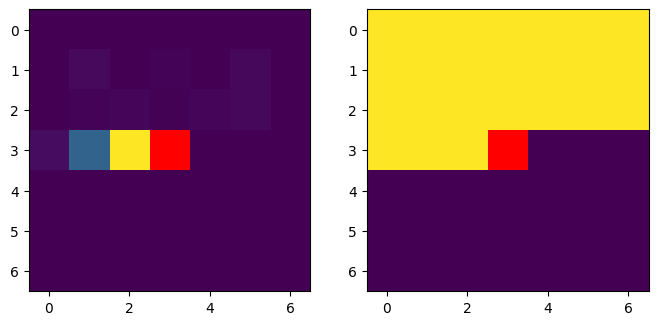

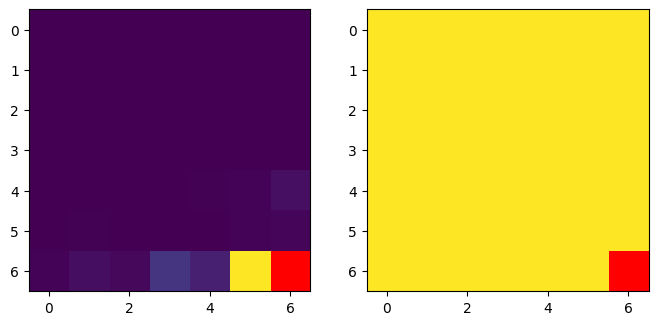

In [17]:
visualize_receptive_field(PixelCNN(in_channels=1, hidden_channels=20, num_embeddings=256, input_transform=transforms.Lambda(lambda x: x)), (1, 1, 7, 7), 3, 3)
visualize_receptive_field(PixelCNN(in_channels=1, hidden_channels=20, num_embeddings=256, input_transform=transforms.Lambda(lambda x: x)), (1, 1, 7, 7), 6, 6)

In [36]:
model = PixelCNN(
    in_channels=1,
    hidden_channels=64,
    num_embeddings=NUM_EMBEDDINGS,
    input_transform=transforms.Lambda(lambda x: x.float())
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.98)

In [37]:
epochs = 30
train_loss_arr, val_loss_arr = [], []

for epoch in range(epochs):
    train_loss = 0.
    model.train()
    for images, _ in train_loader:
        images = images.to(device)
        
        quantized_indices = vq(encoder(next(iter(train_loader))[0].to(device)), return_indices=True).type(torch.long).unsqueeze(1)
        
        output = model(quantized_indices)

        nll = F.cross_entropy(output, quantized_indices, reduction='none')
        bpd = nll.mean(dim=[1, 2, 3]) * np.log2(np.exp(1))
        loss = bpd.mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += images.shape[0] * loss.item()
    # scheduler.step()

    val_loss = 0.
    # model.eval()
    # for images, _ in val_dataloader:
    #     images = images.to(device)
        
    #     output = model(images)

    #     nll = F.cross_entropy(output, images, reduction='none')
    #     bpd = nll.mean(dim=[1, 2, 3]) * np.log2(np.exp(1))
    #     loss = bpd.mean()

    #     val_loss += images.shape[0] * loss.item()

    train_loss /= len(train_loader.dataset)
    # val_loss /= len(val_dataloader.dataset)

    train_loss_arr.append(train_loss)
    # val_loss_arr.append(val_loss)

    print(f'[{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}] [Epoch {epoch:3d}] Train Loss: {train_loss:.5f}  -  Validation Loss: {val_loss:.5f}')


[2023-07-01 16:05:34] [Epoch   0] Train Loss: 1.11486  -  Validation Loss: 0.00000
[2023-07-01 16:06:01] [Epoch   1] Train Loss: 0.88128  -  Validation Loss: 0.00000
[2023-07-01 16:06:29] [Epoch   2] Train Loss: 0.83662  -  Validation Loss: 0.00000
[2023-07-01 16:06:57] [Epoch   3] Train Loss: 0.81225  -  Validation Loss: 0.00000
[2023-07-01 16:07:24] [Epoch   4] Train Loss: 0.79734  -  Validation Loss: 0.00000
[2023-07-01 16:07:52] [Epoch   5] Train Loss: 0.78685  -  Validation Loss: 0.00000
[2023-07-01 16:08:20] [Epoch   6] Train Loss: 0.77837  -  Validation Loss: 0.00000
[2023-07-01 16:08:48] [Epoch   7] Train Loss: 0.77038  -  Validation Loss: 0.00000
[2023-07-01 16:09:16] [Epoch   8] Train Loss: 0.76405  -  Validation Loss: 0.00000
[2023-07-01 16:09:44] [Epoch   9] Train Loss: 0.75738  -  Validation Loss: 0.00000
[2023-07-01 16:10:12] [Epoch  10] Train Loss: 0.75257  -  Validation Loss: 0.00000
[2023-07-01 16:10:36] [Epoch  11] Train Loss: 0.74643  -  Validation Loss: 0.00000
[202

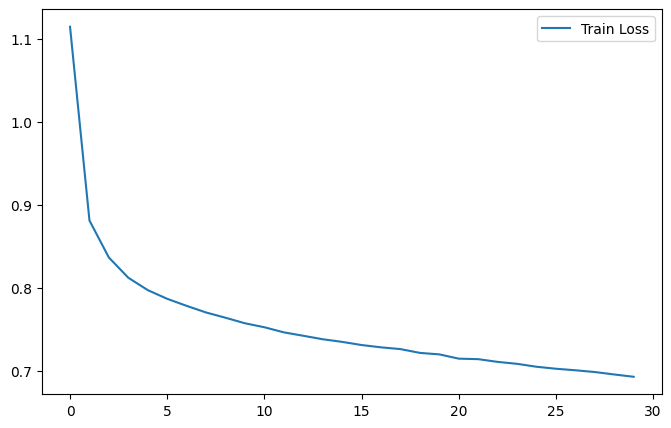

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_arr)
# plt.plot(val_loss_arr)
plt.legend(['Train Loss']) # , 'Validation Loss'
plt.show();

In [41]:
# torch.save(model.state_dict(), 'pixelcnn.pth')

# model.load_state_dict(torch.load('pixelcnn.pth'));

In [42]:
def sample_image(model, img_shape, device):
    img = torch.zeros(img_shape).to(device)

    _, C, H, W = img_shape
    for h in range(H):
        for w in range(W):
            for c in range(C):
                pred = model(img[:, :, :h+1, :])
                prob = F.softmax(pred[:, :, c, h, w], dim=-1)
                img[:, c, h, w] = torch.multinomial(prob, num_samples=1).squeeze(-1)
    
    return img

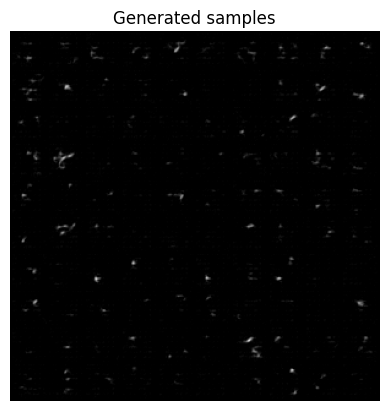

In [43]:
random_indices = torch.randint(low=0, high=NUM_EMBEDDINGS, size=(100, 1, 7, 7)).to(device)
quantized = vq.embedding(random_indices.type(torch.long)).transpose(1, -1).squeeze(-1)
decoded = decoder(quantized)
show_images(decoded.detach().cpu().clip(0, 1), title=f'Generated samples', nrow=10);

torch.Size([100, 1, 7, 7])


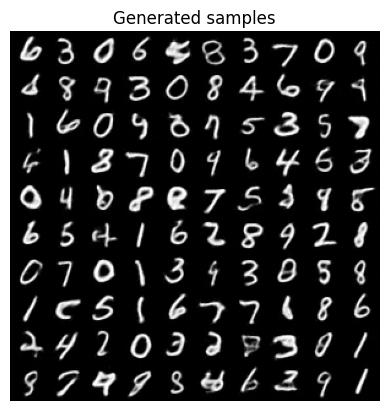

In [44]:
model.eval()
sample = sample_image(model, (100, 1, 7, 7), device)
print(sample.shape)
quantized = vq.embedding(sample.type(torch.long)).transpose(1, -1).squeeze(-1)
decoded = decoder(quantized)
show_images(decoded.detach().cpu().clip(0, 1), title=f'Generated samples', nrow=10);